## Кредитный скоринг на клиентах, уже бравших кредиты

client_id	     идентификатор клиента
education	     уровень образования
sex	             пол заёмщика
age    	         возраст заёмщика
car	             флаг наличия автомобиля
car_type	     флаг автомобиля-иномарки
decline_app_cnt	 количество отказанных прошлых заявок
good_work	     флаг наличия «хорошей» работы
bki_request_cnt	 количество запросов в БКИ
home_address	 категоризатор домашнего адреса
work_address	 категоризатор рабочего адреса
income	         доход заёмщика
foreign_passport наличие загранпаспорта
default	         наличие дефолта

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
RANDOM_SEED = 42

In [3]:
df = pd.read_csv('train-scoring.csv')

In [4]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


In [5]:
len(df)

73799

In [6]:
df.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


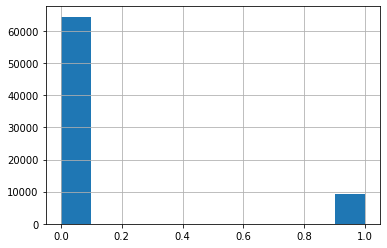

In [8]:
df.default.hist()

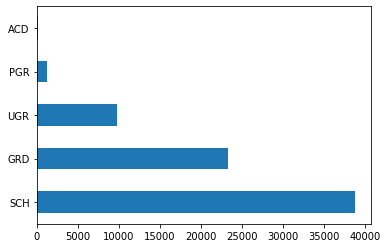

In [9]:
df.education.value_counts().plot.barh()

In [10]:
df.loc[pd.isna(df.education), 'education'] = 'SCH'

In [11]:
def analyse_numeric(df, column, bns=30):
    '''Визуализирует распределения числовых переменных.
       Принимает параметром строковое название столбца
       Печатает различные статистические показатели и строит гистограмму'''
    count = df[column].count()
    mean = df[column].mean()
    std = df[column].std()
    median = df[column].median()
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = df[column].min()
    range_max = df[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = df[column].loc[(df[column] < perc25 - 1.5*IQR) | (df[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(df[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    plt.figure()
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                    .hist(bins = bns, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = bns, range = range_, label = 'Выбросы')
    
    plt.legend()

Количество: 73799, Среднее: 39.281, Стандартное отклонение: 11.520.
Минимум: 21, 25-й перцентиль: 30.0, Медиана: 37.0, 75-й перцентиль: 48.0, Максимум: 72, IQR: 18.0.
Количество пропусков в столбце:  0
Границы выбросов: [3.0, 75.0]. Количество выбросов:  0


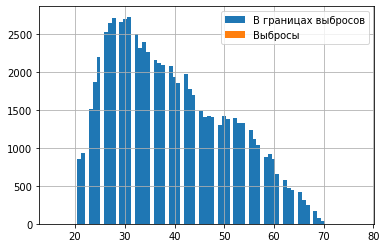

In [12]:
analyse_numeric(df, 'age', 80)

Количество: 73799, Среднее: 0.276, Стандартное отклонение: 0.804.
Минимум: 0, 25-й перцентиль: 0.0, Медиана: 0.0, 75-й перцентиль: 0.0, Максимум: 33, IQR: 0.0.
Количество пропусков в столбце:  0
Границы выбросов: [0.0, 0.0]. Количество выбросов:  12585


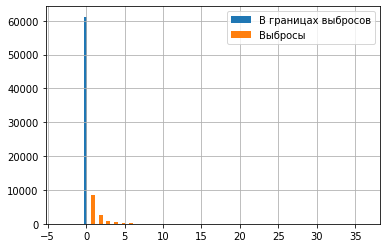

In [13]:
analyse_numeric(df, 'decline_app_cnt', 80)

Количество: 73799, Среднее: 2.000, Стандартное отклонение: 2.252.
Минимум: 0, 25-й перцентиль: 0.0, Медиана: 1.0, 75-й перцентиль: 3.0, Максимум: 53, IQR: 3.0.
Количество пропусков в столбце:  0
Границы выбросов: [-4.5, 7.5]. Количество выбросов:  1755


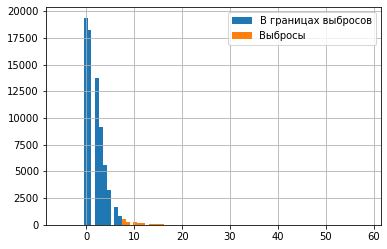

In [14]:
analyse_numeric(df, 'bki_request_cnt', 80)

Количество: 73799, Среднее: 41099.775, Стандартное отклонение: 46166.322.
Минимум: 1000, 25-й перцентиль: 20000.0, Медиана: 30000.0, 75-й перцентиль: 48000.0, Максимум: 1000000, IQR: 28000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-22000.0, 90000.0]. Количество выбросов:  4695


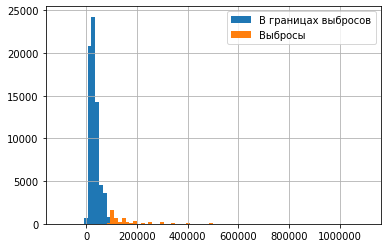

In [15]:
analyse_numeric(df, 'income', 80)

In [16]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

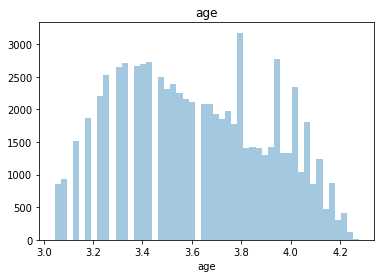

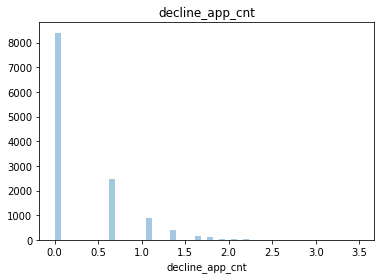

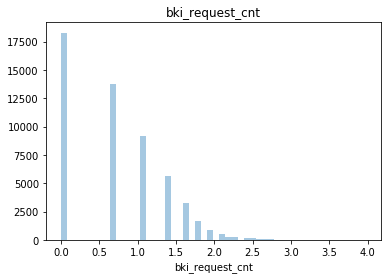

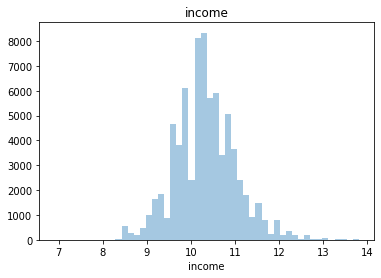

In [17]:
for i in num_cols:
    plt.figure()
    sns.distplot(np.log(df[i][df[i] > 0].dropna()), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [18]:
def get_boxplot(df, column, target):
    '''Строит boxplot - график для визуализации влияния признака column
       на целевую переменную target.
       Параметры:
       - df - датафрейм
       - column - столбец датафрейма (влияющий признак)
       - target - целевая переменная'''
    fig, ax = plt.subplots(figsize = (10, 3))
    sns.boxplot(x=column, y=target, 
                data=df[[column, target]],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

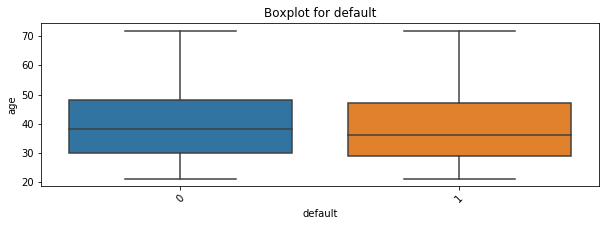

In [19]:
get_boxplot(df, 'default', 'age')

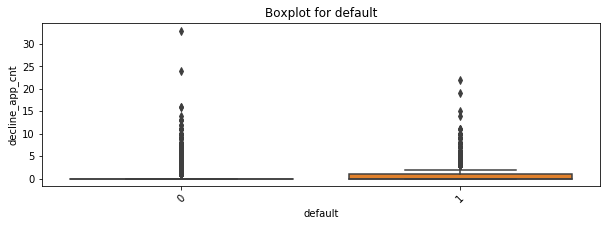

In [20]:
get_boxplot(df, 'default', 'decline_app_cnt')

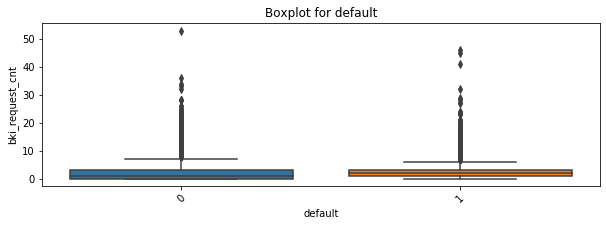

In [21]:
get_boxplot(df, 'default', 'bki_request_cnt')

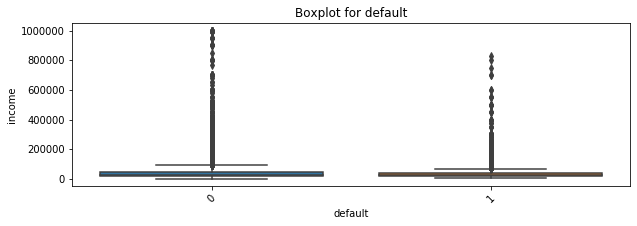

In [22]:
get_boxplot(df, 'default', 'income')

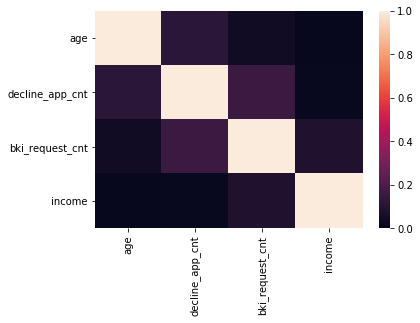

In [23]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [24]:
df[num_cols].corr().abs()

,age,decline_app_cnt,bki_request_cnt,income
age,1.000000,0.111175,0.046265,0.018900
decline_app_cnt,0.111175,1.000000,0.155894,0.021687
bki_request_cnt,0.046265,0.155894,1.000000,0.082983
income,0.018900,0.021687,0.082983,1.000000


Значимость непрерывных переменных

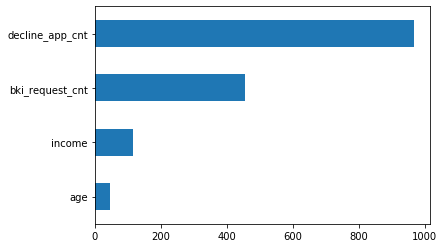

In [25]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Категориальные переменные

In [26]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [27]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [28]:
# Для бинарных признаков мы будем использовать LabelEncoder

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


Значимость категориальных и бинарных переменных

In [29]:
cat_cols = ['education', 'home_address', 'work_address']

In [30]:
df.education.value_counts()

SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [31]:
df.home_address.value_counts()

2    39956
1    32585
3     1258
Name: home_address, dtype: int64

In [32]:
df.work_address.value_counts()

3    44959
2    20506
1     8334
Name: work_address, dtype: int64

In [33]:
df.education = df.education.apply(lambda x: 0 if x=='SCH' else 1 if x=='GRD' else 2 if x=='UGR' else 3 if x=='PGR' else 4)

In [34]:
df.education.value_counts()

0    39167
1    23365
2     9816
3     1257
4      194
Name: education, dtype: int64

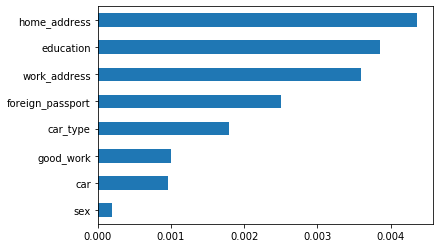

In [35]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [36]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [37]:
X_cat

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [38]:
X_cat.shape

(73799, 11)

In [39]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df[num_cols].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [40]:
# Объединяем

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

Подготовка признаков для модели завершена.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [42]:
print('All Clients:', len(Y))
print('Test Clients:', len(y_test))

All Clients: 73799
Test Clients: 14760


In [43]:
print('Defaulted on Test:', sum(y_test))

Defaulted on Test: 1827


Обучаем логистическую регрессию

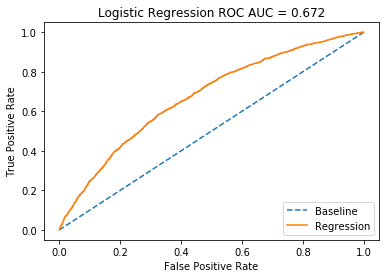

In [44]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [45]:
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred).T
print('Confusion matrix:\n{}'.format(conf_mat))

Confusion matrix:
[[12907  1810]
 [   26    17]]


In [46]:
12907 + 1810 + 26 + 17

14760

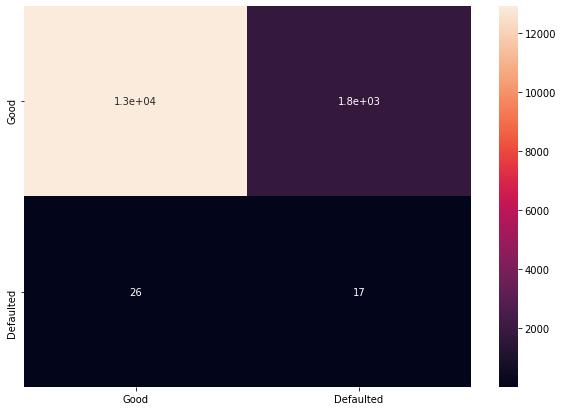

In [47]:
import seaborn as sn
class_names = ['Good', 'Defaulted']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);